# Language identification model construction

## Objectives

* Perform a simple exploration over a text dataset of language identification
* Build a simple neural network for automatic identification of language (english, spanish and german)

## Requirements

For installing all necessar requirements use the language_identification.yml and the following commands   
```
conda env create -f language_identification.yml   
conda activate language_identification
```  
For installing a kernel for running this notebook create a new ipython kernel within the activated environment
```
python -m ipykernel install --user --name=language_detection
```
  

In [1]:
# Run only if you want to install the packages from inside the notebook
# %pip install tensorflow==2.8.0 pandas==1.3.5 numpy==1.21.5 scikit-learn==1.0.2 matplotlib==3.2.2 nltk==3.2.5 pydot==1.3.0

In [3]:
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import pandas as pd
import sys
import requests
import os
import numpy as np
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn import preprocessing

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ralfk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ralfk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Check TF version

print(tf.__version__)

2.8.0


# Data importation

In this step, we will use a dataset of 90k samples consisting of text passages and their corresponding language label. This dataset contains samples from 20 different languages. However for our example we will focus on 3 different languages: English, Spanish and German. [Further information can be found here](https://huggingface.co/datasets/papluca/language-identification)

In [5]:
# Define our directory for saving the dataset

DATA_DIRECTORY = "../data"

In [6]:
# Download data and save it into the data folder

# if 'win' in sys.platform:
#     if DATA_DIRECTORY in os.listdir():
#        !powershell -Command rm -r -fo {DATA_DIRECTORY}
#     !powershell -Command mkdir {DATA_DIRECTORY}
# else:
#    if DATA_DIRECTORY in os.listdir():
#        !rm -rf {DATA_DIRECTORY}
#    !mkdir {DATA_DIRECTORY}

with open(f"{DATA_DIRECTORY}/train.csv", "wb") as f:
    f.write(requests.get("https://huggingface.co/datasets/papluca/language-identification/resolve/main/train.csv").content)

with open(f"{DATA_DIRECTORY}/test.csv", "wb") as f:
    f.write(requests.get("https://huggingface.co/datasets/papluca/language-identification/resolve/main/test.csv").content)

with open(f"{DATA_DIRECTORY}/valid.csv", "wb") as f:
    f.write(requests.get("https://huggingface.co/datasets/papluca/language-identification/resolve/main/valid.csv").content)


In [7]:
# Load data in pandas for filtering

train_df = pd.read_csv(f"{DATA_DIRECTORY}/train.csv")
val_df = pd.read_csv(f"{DATA_DIRECTORY}/valid.csv")
test_df = pd.read_csv(f"{DATA_DIRECTORY}/test.csv")

In [8]:
# Select only "en", "es" and "de"
lang_list = ["es", "en", "de"]

train_df = train_df.loc[train_df.labels.isin(lang_list)]
val_df = val_df.loc[val_df.labels.isin(lang_list)]
test_df = test_df.loc[test_df.labels.isin(lang_list)]

# Data exploration

In this step, we will perform a simple analysis of some important characteristics of our dataset:

* Word frequency distribution
* Distribution of labels 
* Text passage length distribution

In [9]:
# We calculate a list of words (tokens) which will be used for evaluate the distribution of
# tokens in the dataset

# We declare a stoplist for the three used languages
stoplist = [stopwords.words(lang) for lang in ["english", "spanish", "german"]]
stoplist = set([word for lang_list in stoplist for word in lang_list])

# Now, only for visualization purposes we create a listh with all the tokens
word_list = []
for sentence in train_df["text"].to_list():
    word_list += [word for word in word_tokenize(sentence) if word not in stoplist]

print(len(word_list))

227718


Our corpus consists of 227K different words.

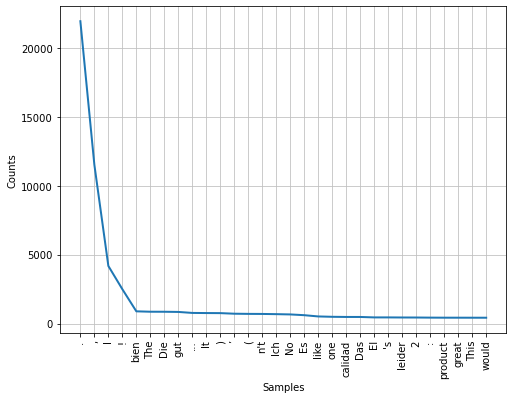

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
plt.figure(figsize=(8, 6)) 

fd = FreqDist(word_list)
fd.plot(30)


In [11]:
# Review the distribution of labels

train_df.labels.value_counts()

es    3500
de    3500
en    3500
Name: labels, dtype: int64

## Exploring the length of the text sequences

Before we define a base architecture in TensorFlow, we must find a good value for the size of the input of the model. We evaluate the average size of each sample of the corpus.

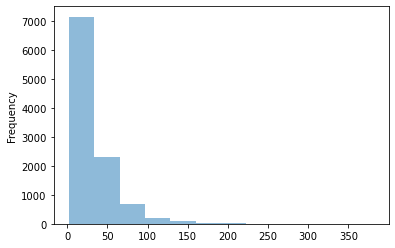

In [12]:
# We then evaluate the size of each sentence in the corpus

splitted_text = train_df['text'].apply(lambda txt: txt.split(' '))
splitted_text_len = splitted_text.apply(lambda x: len(x))
ax = splitted_text_len.plot.hist(bins=12, alpha=0.5)

In [13]:
print("Average length: {}".format(splitted_text_len.mean()))
print("Maximum length: {}".format(splitted_text_len.max()))
print("Standard deviation length: {}".format(splitted_text_len.std()))

Average length: 31.605238095238096
Maximum length: 381
Standard deviation length: 29.969598705150613


We have selected $50$, as it covers up to 68% of the data (one standard deviation). Sequences longer than $50$ words will be chunked. **This is done for the sake of simplicity** 

# Data preparation
## Using `tf.data` for creating the dataset

`tf.data` is one of the most useful libraries for accessing datasets in TensorFlow. It provides several handlers for reading and creating usable datasets with low memory footprint. In this section we:

* Transform the language labels to integers
* Build the datasets using `tf.data`
* Transform the text input into sequences of up to 50 integers (vectorization)

In [14]:
# Create dictionary for encoding labels
# This is done using LabelEncoder from scikit-learn
# It's quite useful when the number if classes is high

le = preprocessing.LabelEncoder()
le.fit(lang_list)

num_classes = len(le.classes_)

train_labels = tf.keras.utils.to_categorical(le.transform(train_df.pop('labels')), num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(le.transform(val_df.pop('labels')), num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(le.transform(test_df.pop('labels')), num_classes=num_classes)

In [15]:
# We build then the datasets using tf.data
raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df["text"].to_list(), train_labels)) # X, y
raw_val_ds = tf.data.Dataset.from_tensor_slices((val_df["text"].to_list(), val_labels))
raw_test_ds = tf.data.Dataset.from_tensor_slices((test_df["text"].to_list(), test_labels))

In [16]:
# Exploring a sample of the corpus

batch_size = 32
seed = 42

for text, label in raw_train_ds.take(1):
    print("Text: ", text.numpy())
    print("Label:", label.numpy())

Text:  b'Un producto de una calidad y capacidad incre\xc3\xadbles que ser\xc3\xa1 el placer de todo amante de la tecnolog\xc3\xada'
Label: [0. 0. 1.]


As you can see, the dataset is still raw, which means, it's still composed of text sequences.

## Preprocessing the dataset using `tf.keras.layers.TextVectorization`

Before we feed our dataset to the model, we have to build a vectorized representation of each text using `tf.keras.layers.TextVectorization`. This layer can help to:

* Preprocess the text data using common and custom standardization techniques
* Transforms words into integers ("book" --> 45) 

We decided to keep the top $10.000$ most frequent words using the `TextVectorization` class.

In [17]:
# Prepare dataset for training

max_features = 10000 # top 10K most frequent words
sequence_length = 50 # We defined it in the previous data exploration section

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

This step is important to perform it only on the training set. The `adapt()` method will learn the vocabulary for our dataset

In [18]:
# train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_df["text"].to_list()) # vectorize layer is fitted to the training data

In [19]:
# Helper for visualizing the processed input
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [20]:
# Reviewing how a sample of the corpus will be fed to the model

text_batch, label_batch = next(iter(raw_train_ds.batch(64)))
first_review, first_label = text_batch[0], label_batch[0]
print("First text: ", first_review)
print("Language (label)", le.inverse_transform([np.argmax(first_label)]))
print("Vectorized text", vectorize_text(first_review, first_label))

First text:  tf.Tensor(b'Un producto de una calidad y capacidad incre\xc3\xadbles que ser\xc3\xa1 el placer de todo amante de la tecnolog\xc3\xada', shape=(), dtype=string)
Language (label) ['es']
Vectorized text (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  39,  112,    5,   61,   85,   11, 2032,    1,    7, 2601,   16,
           1,    5,  162,    1,    5,   13, 7610,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


In [21]:
# Create the final datasets using the vectorize_layer

train_ds = raw_train_ds.map(lambda x, y: (vectorize_layer(x), y)) # returns vectorize_layer(text), label
val_ds = raw_val_ds.map(lambda x, y: (vectorize_layer(x), y))
test_ds = raw_test_ds.map(lambda x, y: (vectorize_layer(x), y))

In [22]:
# Applying cache techniques for improving inference and training time
# It allows tensorflow to prepare the data while it trains the model

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.batch(batch_size=batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size=batch_size)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size=batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

# Model training and specification

Our simple architecture is defined as follows:
* `Embedding` layer for building a more dense and compact representation for each of the top 10.000 most frequent words
* `Dropout` layer for improving regularization
* `GlobalAveragePooling1D` for returning a fixed-length ouput vector for each example. It averages over the sequence dimension, allowing the model to handle variable size inputs (less than 50) in a simple way.
* `Dense` layer for the logits of each class (es, en, de)

In [23]:
# Model training

embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
__________________________________________________

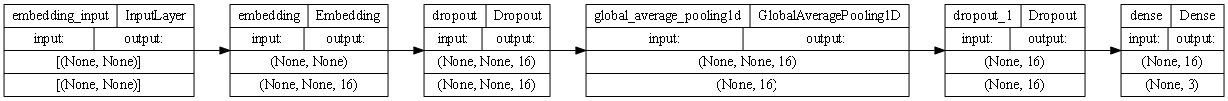

In [24]:
tf.keras.utils.plot_model(model=model , rankdir="LR", dpi=72, show_shapes=True)


In [25]:
# Specify loss, optimizer and metrics

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
# Train

epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
329/329 [==============================] - 3s 7ms/step - loss: 0.8890 - accuracy: 0.8609 - val_loss: 0.6303 - val_accuracy: 0.9880

In [27]:
# Evaluate the model

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

47/47 [==============================] - 0s 6ms/step - loss: 0.3980 - accuracy: 0.9993
Loss:  0.39804303646087646
Accuracy:  0.9993333220481873


Keys of the history variable
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


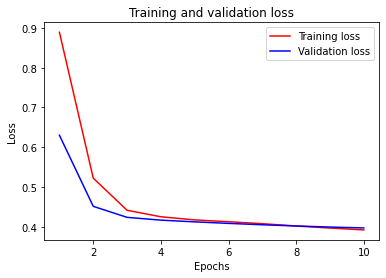

In [28]:
# Plot loss

history_dict = history.history
print("Keys of the history variable")
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


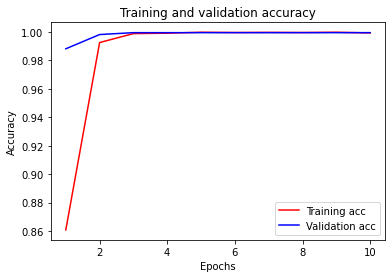

In [29]:
# Plot accuracy

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [55]:
# Now we test it with some predictions
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    maxm = np.max(x, axis=1, keepdims=True)  # returns max of each row and keeps same dims
    e_xm = np.exp(x - maxm)  # subtracts each row with its max value
    summ = np.sum(e_xm, axis=1, keepdims=True)  # returns sum of each row and keeps same dims
    return e_xm / summ

examples = [
# "All the love stories have something in common. Once upon a time, I have that experience too. but I can not remember it clearly. All I can remember is that love returns with another man bringing new hopes to me."
#    "Esto me pareció increíble",
#   "Alles hat ein Ende, nur die Wurst hat zwei",
    "Oh Lord, won't you buy me a Mercedes-Benz? Oh Lord, won't you buy me a Mercedes-Benz? Oh Lord, won't you buy me a Mercedes-Benz? Oh Lord, won't you buy me a Mercedes-Benz? ",
    "Auch mal eine ruhige Kugel schieben",
#    "Oder sich einen Algorithmus anschauen",
#    "Podría decirme más sobre la cultura española, mexicana, argentina o colombiana?",
#    "Try to understand them, because the English that we speak today is based on what our great, great, great, great grandparents spoke before!"
#    "Gänzlich wunderbar öffnet sich die Tür der Welt dem ganzen Anblick der Natur"
]

examples_vectorized = vectorize_layer(examples)

logits = model.predict(examples_vectorized)
probits = softmax(logits)
idx_predictions = np.argmax(probits, axis=1)
print("Probabilities: {}".format(np.max(probits, axis=1)))
print("Corresponding classes: {}".format(le.inverse_transform(idx_predictions)))

Probabilities: [0.65150654 0.3845096 ]
Corresponding classes: ['en' 'de']


In [30]:
# Save the model

if "model" not in os.listdir():
    !mkdir model

model.save('model/simple_mlp_novectorize.h5')

**Achtung**: Here we are only saving the tf model. Neither the vectorize layer nor the LabelEncoder weren't saved. 

In [31]:
# Load the model
saved_model = tf.keras.models.load_model('saved_model/simple_mlp_novectorize.h5')